In [1]:
from glob import glob
from src import Module, DataModule, DatasetFCI, DatasetFCIm
import torch 
import torchmetrics 
from tqdm import tqdm
import os 
from skimage import io
import shutil
import numpy as np
import pandas as pd

In [162]:
checkpoints = glob('./checkpoints/*')
checkpoints

['./checkpoints/unetpp-rs50-fcim-lrs-val_metric=0.67217-epoch=16.ckpt',
 './checkpoints/unetpp-rs50-fcim-lrs-epoch=29.ckpt',
 './checkpoints/unetpp-rs50-fcim-lrs-epoch=99.ckpt',
 './checkpoints/unetpp-rs50-fcim-lrs-focal-val_metric=0.00334-epoch=0.ckpt',
 './checkpoints/unetpp-rs50-fcim-da-epoch=29.ckpt',
 './checkpoints/unetpp-rs50-fcim-da-epoch=29-v1.ckpt',
 './checkpoints/unetpp-rs50-fcim-da-val_metric=0.67048-epoch=26.ckpt',
 './checkpoints/unetpp-rs50-fcim-lrs-focal-epoch=9.ckpt',
 './checkpoints/unetpp-rs50-fcim-lrs-val_metric=0.68205-epoch=15.ckpt',
 './checkpoints/unetpp-rs50-fcim-da-val_metric=0.66485-epoch=29.ckpt']

In [163]:
name = "unetpp-rs50-fcim-da-val_metric=0.67048-epoch=26.ckpt"
checkpoint = f'./checkpoints/{name}'

# module = Module.load_from_checkpoint(checkpoint)

state_dict = torch.load(checkpoint, map_location='cpu')['state_dict']
module = Module({"encoder": "timm-resnest50d", "in_chans": 5, "pretrained": None, "padding": 1, "mask_loss": True, "architecture": "UnetPlusPlus"})
module.load_state_dict(state_dict)


<All keys matched successfully>

In [4]:
class Identity:
    def __call__(self, x):
        return x

class Rot90:
    def __init__(self, axes=(1,2)):
        self.axes = axes
    def __call__(self, x):
        return torch.rot90(x, 1, self.axes)

class Rot180:
    def __init__(self, axes=(1,2)):
        self.axes = axes
    def __call__(self, x):
        return torch.rot90(x, 2, self.axes)

class Rot270:
    def __init__(self, axes=(1,2)):
        self.axes = axes
    def __call__(self, x):
        return torch.rot90(x, 3, self.axes)

class Flip:
    def __init__(self, axis=1):
        self.axis = axis
    def __call__(self, x):
        return torch.flip(x, [self.axis])

class Transpose:
    def __init__(self, axes=(1,2)):
        self.axes = axes
    def __call__(self, x):
        return torch.transpose(x, self.axes[0], self.axes[1])

trans = [
    (Identity(), Identity()),
    (Rot90(), Rot270()),
    (Rot180(), Rot180()),
    (Rot270(), Rot90()),
    (Flip(1), Flip(1)),
    (Flip(2), Flip(2)),
    (Transpose(), Transpose()),
]

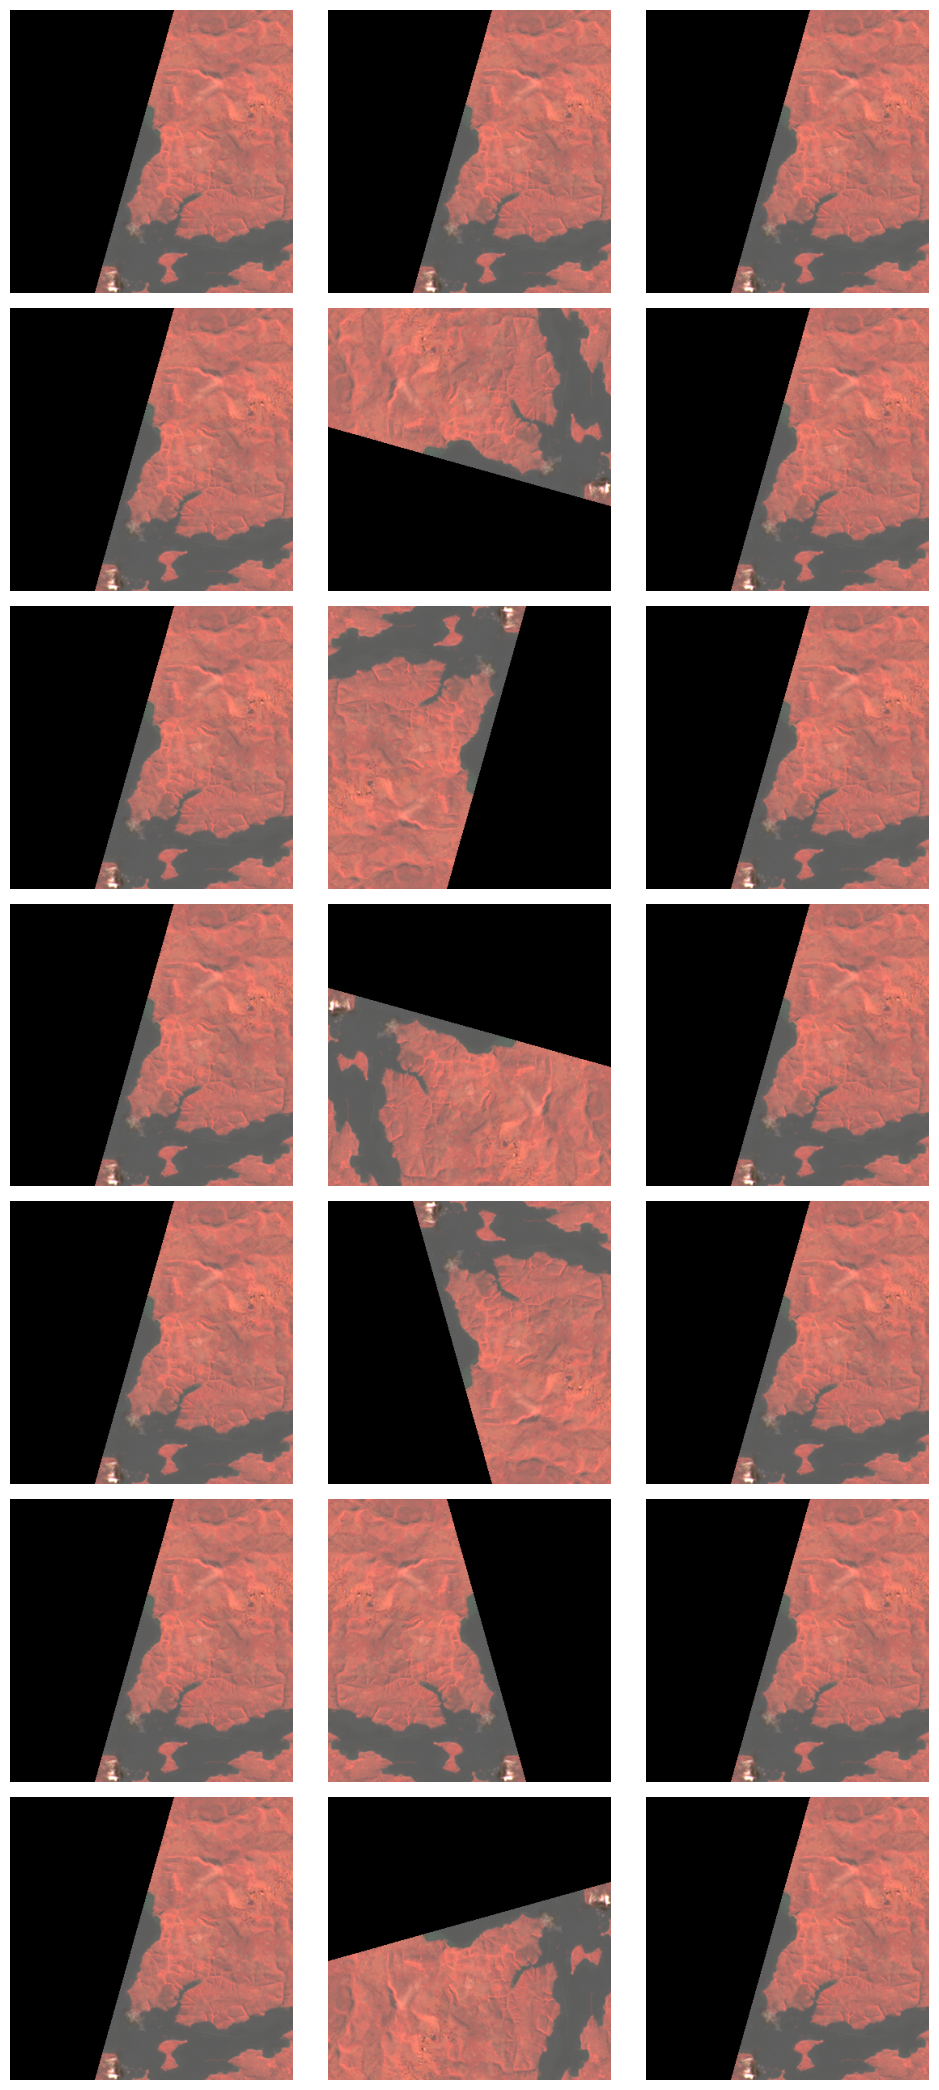

In [5]:
import torch 
import matplotlib.pyplot as plt 

dm = DataModule(Dataset="DatasetFCIm", batch_size=1)
dm.setup()

dl = dm.train_dataloader()
imgs, masks = next(iter(dl))

def get_image(x):
	return x[0][...,:3]

fig, ax = plt.subplots(len(trans), 3, figsize=(10, 3*len(trans)))
for i, (t1, t2) in enumerate(trans):
	ax[i, 0].imshow(get_image(imgs))
	ax[i, 0].axis('off')
	ax[i, 1].imshow(get_image(t1(imgs)))
	ax[i, 1].axis('off')
	ax[i, 2].imshow(get_image(t2(t1(imgs))))
	ax[i, 2].axis('off')
plt.tight_layout()
plt.show()

Ensemble dice: 0.49463
False True


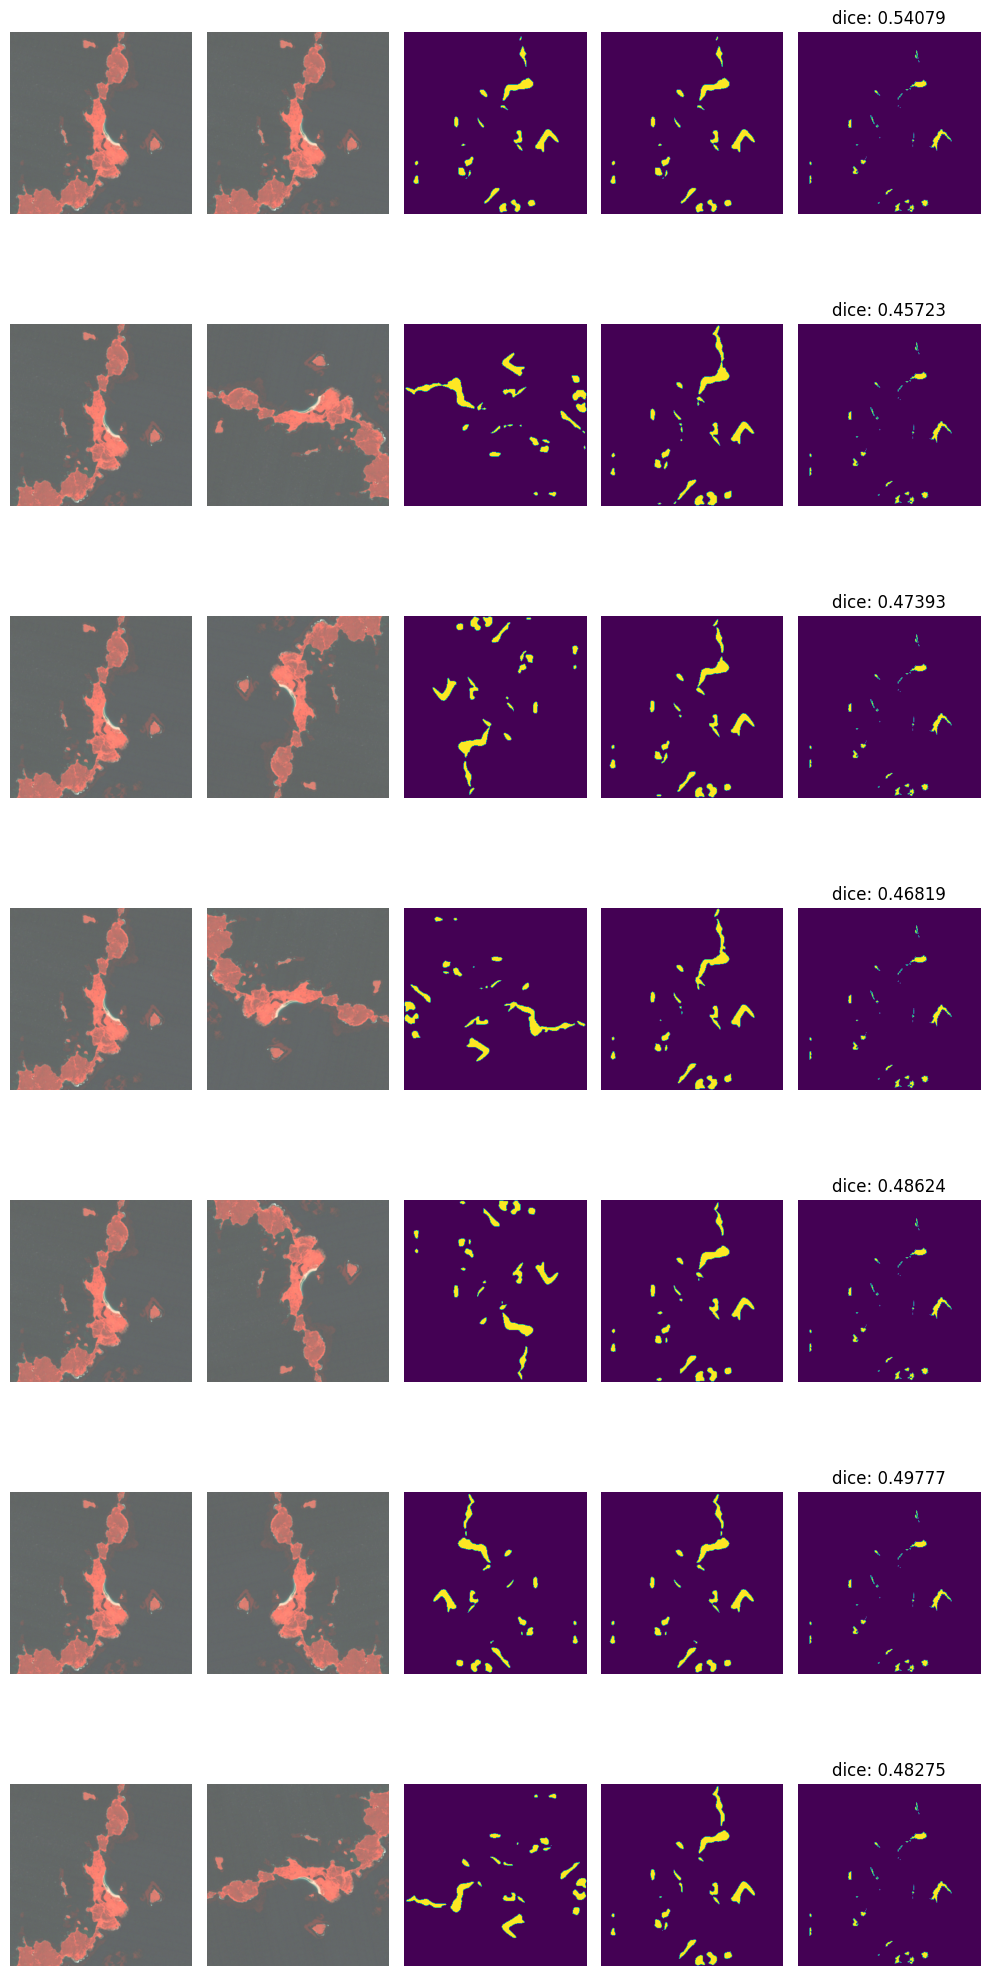

In [151]:
trans = [
    (Identity(), Identity()),
    (Rot90(), Rot270(axes=(2, 3))),
    (Rot180(), Rot180(axes=(2, 3))),
    (Rot270(), Rot90(axes=(2, 3))),
    (Flip(1), Flip(2)),
    (Flip(2), Flip(3)),
    (Transpose(), Transpose(axes=(2, 3))),
]

dm = DataModule(Dataset="DatasetFCIm", batch_size=1)
dm.setup()

dl = dm.train_dataloader()
imgs, masks = next(iter(dl))

def get_image(x):
	return x[0][...,:3]

fig, ax = plt.subplots(len(trans), 5, figsize=(10, 3*len(trans)))
preds, dices, ws = [], [], []
for i, (t1, t2) in enumerate(trans):
	ax[i, 0].imshow(get_image(imgs))
	ax[i, 0].axis('off')
	ax[i, 1].imshow(get_image(t1(imgs)))
	ax[i, 1].axis('off')
	module.eval()
	module.cuda()
	metric = torchmetrics.Dice()
	with torch.no_grad():
		x = imgs[...,:-1]
		x = x.cuda()
		y_hat = torch.sigmoid(module(t1(x)).cpu()) 
		y_hat_t = t2(y_hat) 
		w = y_hat_t
		metric(y_hat_t, masks.unsqueeze(1))
	ax[i, 2].imshow(y_hat[0,0] > 0.5)
	ax[i, 2].axis('off')
	ax[i, 3].imshow(y_hat_t[0,0] > 0.5)
	ax[i, 3].axis('off')
	ax[i, 4].imshow(masks[0])
	ax[i, 4].axis('off')
	dice = metric.compute().item()
	dices.append(dice)
	ax[i, 4].set_title(f"dice: {dice:.5f}")
	# preds.append(y_hat_t)
	# preds.append(y_hat_t * w)
	preds.append(w * (y_hat_t > 0.5))
	ws.append(w)
# y_hat = torch.stack(preds).float().mean(0)
# y_hat = torch.stack(preds).sum(0) /  torch.stack(ws).sum(0)
y_hat = torch.stack(preds).sum(0) / len(trans)
y_hat = torch.round(y_hat)
metric = torchmetrics.Dice()
metric(y_hat, masks.unsqueeze(1))
adice = metric.compute().item()
print(f"Ensemble dice: {adice:.5f}")
print(adice >= np.max(dices), adice >= np.mean(dices))
plt.tight_layout()
plt.show()

In [180]:
trans = [
    (Identity(), Identity()),
    (Rot90(), Rot270(axes=(2, 3))),
    (Rot180(), Rot180(axes=(2, 3))),
    (Rot270(), Rot90(axes=(2, 3))),
    (Flip(1), Flip(2)),
    (Flip(2), Flip(3)),
    (Transpose(), Transpose(axes=(2, 3))),
]

def eval(model, device=0, mask_loss=False):
	# dm = DataModule(false_color=True, t=[4], val_trans={'Resize': {"height":384, 'width':384}})
	dm = DataModule(Dataset="DatasetFCIm")
	dm.setup()
	model.eval()
	model.cuda(device)
	metric = torchmetrics.Dice().cuda(device)
	with torch.no_grad():
		pbar = tqdm(dm.val_dataloader())
		for batch in pbar:
			x, y = batch
			if mask_loss: x = x[...,:-1]
			x = x.cuda(device)
			preds = []
			for t1, t2 in trans:
				y_hat = t2(model(t1(x)))
				probas = torch.sigmoid(y_hat)
				# preds.append(probas * (probas > 0.5))
				preds.append(probas)
			y_hat = torch.stack(preds).float().mean(0) 
			metric(y_hat, y.cuda(device).unsqueeze(1))
			pbar.set_description(f'Dice: {metric.compute().cpu().item():.5f}')

In [181]:
eval(module, mask_loss=True)

  0%|          | 0/36 [00:00<?, ?it/s]

Dice: 0.67516: 100%|██████████| 36/36 [01:30<00:00,  2.51s/it]


In [182]:
images = glob('data/test_satellite/*.tif')
len(images)

1426

In [183]:
image_ids = sorted([image.split('/')[-1].split('_')[0] for image in images])
len(image_ids)

1426

In [184]:
test_ds = DatasetFCIm(image_ids, mode="test", image_folder="test_satellite")

image, image_id = test_ds[0]
image.shape, image.dtype, image.max(), image.min(), image_id

((350, 350, 6), dtype('float32'), 1.0, 0.0, 'AA408972')

In [185]:
def generate_masks(model, device=1, mask_loss=False, th=0.5):
	trans = [
		(Identity(), Identity()),
		(Rot90(), Rot270(axes=(2, 3))),
		(Rot180(), Rot180(axes=(2, 3))),
		(Rot270(), Rot90(axes=(2, 3))),
		(Flip(1), Flip(2)),
		(Flip(2), Flip(3)),
		(Transpose(), Transpose(axes=(2, 3))),
	]
	model.eval()
	model.cuda(device)
	images = glob('data/test_satellite/*.tif')
	image_ids = sorted([image.split('/')[-1].split('_')[0] for image in images])
	test_ds = DatasetFCIm(image_ids, mode="test", image_folder="test_satellite")
	test_dl = torch.utils.data.DataLoader(test_ds, batch_size=10, shuffle=False, num_workers=4)
	!rm -rf ./data/test_kelp
	os.makedirs('./data/test_kelp', exist_ok=True)
	with torch.no_grad():
		for batch in tqdm(test_dl):
			x, image_ids = batch
			if mask_loss: x = x[...,:-1]
			x = x.cuda(device)
			preds = []
			for t1, t2 in trans:
				y_hat = t2(model(t1(x)))
				probas = torch.sigmoid(y_hat)
				preds.append(probas)
			y_hat = torch.stack(preds).mean(0)
			y_hat = y_hat > th
			y_hat = y_hat.long().squeeze(1)
			y_hat = y_hat.cpu().numpy().astype('uint8')
			for i, image_id in enumerate(image_ids):
				io.imsave(f'data/test_kelp/{image_id}_kelp.tif', y_hat[i])

In [186]:
generate_masks(module, mask_loss=True)

  0%|          | 0/143 [00:00<?, ?it/s]/tmp/ipykernel_234390/666618656.py:34: UserWarning: data/test_kelp/AA408972_kelp.tif is a low contrast image
  io.imsave(f'data/test_kelp/{image_id}_kelp.tif', y_hat[i])
/tmp/ipykernel_234390/666618656.py:34: UserWarning: data/test_kelp/AA804258_kelp.tif is a low contrast image
  io.imsave(f'data/test_kelp/{image_id}_kelp.tif', y_hat[i])
/tmp/ipykernel_234390/666618656.py:34: UserWarning: data/test_kelp/AB121622_kelp.tif is a low contrast image
  io.imsave(f'data/test_kelp/{image_id}_kelp.tif', y_hat[i])
/tmp/ipykernel_234390/666618656.py:34: UserWarning: data/test_kelp/AB144957_kelp.tif is a low contrast image
  io.imsave(f'data/test_kelp/{image_id}_kelp.tif', y_hat[i])
/tmp/ipykernel_234390/666618656.py:34: UserWarning: data/test_kelp/AB363647_kelp.tif is a low contrast image
  io.imsave(f'data/test_kelp/{image_id}_kelp.tif', y_hat[i])
/tmp/ipykernel_234390/666618656.py:34: UserWarning: data/test_kelp/AB455766_kelp.tif is a low contrast image
  

In [187]:
generated_masks = glob('data/test_kelp/*.tif')
len(generated_masks)

1426

In [188]:
mask = io.imread(generated_masks[0])
mask.shape, mask.dtype, mask.max(), mask.min()

((350, 350), dtype('uint8'), 1, 0)

In [189]:
!rm -rf submission.zip
shutil.make_archive('submission', 'zip', 'data/test_kelp')

'/home/juan/Desktop/competis/KelpWanted/submission.zip'

In [14]:
examples = glob('data/submission_format/*.tif')
len(examples)

1426

In [15]:
mask = io.imread(examples[0])
mask.shape, mask.dtype, mask.max(), mask.min()

((350, 350), dtype('uint8'), 1, 0)